In [5]:
import numpy as np
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.metrics import roc_curve,roc_auc_score
import matplotlib.pyplot as plt

In [6]:
mean_sig = np.array([2.5, 2.5, 2])
variance_sig = 1.5
covariance_sig = np.array([
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]
])*(variance_sig)**2

In [7]:
mean_bkg = np.array([0, 0, 0])
variance_bkg = 1.5
covariance_bkg = np.array([
    [1, 0.8, 0],
    [0.8, 1, 0],
    [0, 0, 1]
])*(variance_bkg**2)

In [8]:
size=10000
sig=np.random.multivariate_normal(mean_sig,covariance_sig,size)
bkg=np.random.multivariate_normal(mean_bkg,covariance_bkg,size)

In [9]:
X=np.concatenate((sig[:,1:],bkg[:,1:]))
Y=np.concatenate((np.ones(size),np.zeros(size)))

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(
  X, Y, test_size=0.15, random_state=42)

In [11]:
class Data(Dataset):
  def __init__(self, X_train, y_train):
    self.X = torch.from_numpy(X_train.astype(np.float32))
    self.y = torch.from_numpy(y_train.astype(np.float32))
    self.len = self.X.shape[0]
  
  def __getitem__(self, index):
    return self.X[index], self.y[index]
  def __len__(self):
    return self.len

In [12]:
traindata = Data(X_train, Y_train)

In [19]:
batch_size=2000
trainloader = DataLoader(traindata, batch_size=batch_size, 
                         shuffle=True, num_workers=1)

In [20]:
input_size=2
hidden_sizes=128
output_size=1
model = nn.Sequential(nn.Linear(input_size, hidden_sizes), # 1st hidden
                      nn.ReLU(),
                      nn.Linear(hidden_sizes, hidden_sizes), # 2nd hidden
                      nn.ReLU(),
                      nn.Linear(hidden_sizes, hidden_sizes), # 3rd hidden
                      nn.ReLU(),
                      nn.Linear(hidden_sizes, output_size), # output layer
                      nn.Sigmoid()
                     )

In [21]:
learning_rate = 0.001
epochs = 40
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
loss_fn = nn.BCELoss()

In [22]:
model.train()
for i in range(1,epochs+1):
    epoch_loss = 0
    for j,(x_train,y_train) in enumerate(trainloader):
        optimizer.zero_grad()
        
        #calculate output
        output = model(x_train)

        #calculate loss
        loss = loss_fn(output,y_train.unsqueeze(1))

        #backprop
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    if i%5==0 or i==1: print(f'Epoch {i+0:03}: | Loss: {epoch_loss/len(trainloader):.5f}')

Epoch 001: | Loss: 0.57214
Epoch 005: | Loss: 0.32918
Epoch 010: | Loss: 0.32804
Epoch 015: | Loss: 0.32455
Epoch 020: | Loss: 0.32622
Epoch 025: | Loss: 0.32649
Epoch 030: | Loss: 0.32570
Epoch 035: | Loss: 0.32524
Epoch 040: | Loss: 0.32742


In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(
  X, Y, test_size=0.9, random_state=42)
testdata = Data(X_test, Y_test)
batch_size=len(Y_test)
testloader = DataLoader(testdata, batch_size=batch_size, 
                         shuffle=True, num_workers=1)
y_pred_list = []
y_true_list = []
model.eval()
with torch.no_grad():
    for X_batch, Y_batch in testloader:
        y_test_pred = model(X_batch)
        y_pred_list.append(y_test_pred.cpu().numpy())
        y_true_list.append(Y_batch.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
y_true_list = [a.squeeze().tolist() for a in y_true_list]

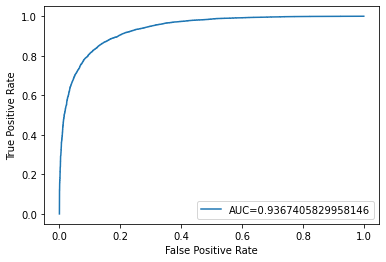

In [24]:
truth_arr=np.asarray(y_true_list[0])
pred_arr=np.asarray(y_pred_list[0])
fpr, tpr, thresholds = roc_curve(truth_arr, pred_arr)
auc = roc_auc_score(truth_arr, pred_arr)
plt.figure()
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()